In [1]:
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
#from tensorflow.keras.utils import to_categorical ## specific  one I wanna use
from tensorflow.keras import utils
#from tensorflow.keras.layers import Input, Dense, Dropout  # Specific ones I wanna use, can just import whole module
from tensorflow.keras import layers 
from tensorflow.keras.models import Model
import h5py
#import tables
import matplotlib.pyplot as plt
#import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight


from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from tensorflow.keras.optimizers import Adam

In [2]:
import tensorflow as tf
gpu_available = tf.test.is_gpu_available()
gpu_available

True

In [3]:
x=1
y=3
x+y

4

In [4]:
# Load the HDF5 file
with h5py.File('DF_event_based.h5', 'r') as hf:
    # Access the dataset by name and load it into a pandas dataframe
    df_total = pd.DataFrame(hf['dataset_name'][:])

with h5py.File('4_event_types_weights.h5', 'r') as f:
    df_weights = f['array'][:]

with h5py.File('predictions_16pad_128_50epoch_4Layers_SEED10.h5', 'r') as f:
    predicted_val = f['val_preds'][:]
    predicted_train = f['train_preds'][:]

with h5py.File('4_event_types_labels.h5', 'r') as f:
    df_labels = f['array'][:]

In [5]:
# df's now have no titles, but doesnt matter for the model obvs.
df_total = df_total.rename(columns={df_total.columns[0]: 'dataset'})
#df_total

In [6]:
df_Xvars = df_total.drop(['dataset'], axis = 1, inplace = False)   #Need to remove dataset (prediction) column
#df_Xvars

In [7]:
x = df_Xvars.values
y = df_labels

X_train, X_valid, y_train, y_valid = train_test_split(x, y, train_size=0.8, test_size=0.2,
                                                      random_state=10)

input_shape = [X_train.shape[1]]
print('There are', input_shape, 'variables in this model')
print('The dataset has', len(y), 'processes')
print(input_shape)

There are [10] variables in this model
The dataset has 881096 processes
[10]


In [10]:
# print(predicted_train.shape)
# print(predicted_val.shape)
# print(X_train.shape)
# print(X_valid.shape)

In [8]:
# X_train = np.hstack((X_train, predicted_train))
# X_valid = np.hstack((X_valid, predicted_val))
print(X_train.shape)
print(X_valid.shape)
print(X_train[:,-1])
print(predicted_train)

input_shape = [X_train.shape[1]] 

(704876, 10)
(176220, 10)
[5. 6. 6. ... 2. 5. 5.]
[[0.61670357]
 [0.4636152 ]
 [0.50274837]
 ...
 [0.20900938]
 [0.7831093 ]
 [0.48962942]]


In [ ]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_class_weight

def create_model(num_hidden_layers=1, units=256, learning_rate=0.001, dropout_rate=0.2, optimizer='adam', activation='relu'):
    model = Sequential([
        BatchNormalization(input_shape=input_shape)
    ])

    for i in range(num_hidden_layers):
        model.add(Dense(units=units, activation=activation))
        model.add(BatchNormalization())
        model.add(Dropout(rate=dropout_rate))

    model.add(Dense(units=1, activation='sigmoid'))

    optimizer = Adam(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy'],
    )

    return model


# Define the parameter grid
param_grid = {
    'batch_size': [32,64,128,256],
    'dropout_rate': [0.2],
    'optimizer': ['adam'],
    'learning_rate': [0.001],
    'activation': ['relu'],
    'num_hidden_layers': [2, 3],
    'units': [64, 128,256, 512]
}


# Define a wrapper function for the MLP NN model
model = KerasClassifier(build_fn=create_model, epochs=20, num_hidden_layers=1, units=256)


from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score

#Define the scoring functions
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'roc_auc': make_scorer(roc_auc_score)
}


# Create a GridSearchCV object
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=scoring,
    refit='roc_auc',
    cv=4,
    verbose=2
)    

early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)

class_weights = compute_class_weight('balanced', np.unique(y_train), y_train)
class_weight = {0: class_weights[0], 1: class_weights[1]} 

# Fit the GridSearchCV object
grid_result = grid_search.fit(X_train, y_train, validation_data=(X_valid, y_valid), class_weight=class_weight, callbacks=[early_stopping])

Fitting 4 folds for each of 32 candidates, totalling 128 fits
[CV] activation=relu, batch_size=32, dropout_rate=0.2, learning_rate=0.001, num_hidden_layers=2, optimizer=adam, units=64 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Train on 528657 samples, validate on 176220 samples
Epoch 1/20
528657/528657 [==============================] - 103s 195us/sample - loss: 0.5917 - accuracy: 0.6875 - val_loss: 0.5725 - val_accuracy: 0.6947
Epoch 2/20
528657/528657 [==============================] - 102s 193us/sample - loss: 0.5844 - accuracy: 0.6947 - val_loss: 0.5703 - val_accuracy: 0.7165
Epoch 3/20
528657/528657 [==============================] - 100s 189us/sample - loss: 0.5830 - accuracy: 0.6955 - val_loss: 0.5704 - val_accuracy: 0.6882
Epoch 4/20
490112/528657 [==========================>...] - ETA: 6s - loss: 0.5830 - accuracy: 0.6949

In [13]:
# Evaluate the performance of the best model
best_params = grid_search.best_params_
best_model = create_model(
    num_hidden_layers=best_params['num_hidden_layers'],
    learning_rate=best_params['learning_rate'],
    dropout_rate=best_params['dropout_rate'],
    optimizer=best_params['optimizer'],
    activation=best_params['activation']
)


In [14]:
grid_search.cv_results_

{'mean_fit_time': array([1660.33202893, 1323.1816892 , 1391.12830091, 1313.53672552,
        1582.42552304, 1780.07863706, 1907.08233541, 1797.87693298,
         781.84909821,  758.77521068,  747.85176259,  732.14523566,
         919.57840371,  908.20163667,  888.74789363,  882.05899119,
         372.87316835,  401.91233087,  391.1923846 ,  379.15049446,
         407.26214021,  425.38494861,  431.13194734,  422.739187  ,
         187.87366575,  177.12929785,  196.83971083,  219.44363832,
         310.01045281,  284.30043232,  280.76442754,  278.85025698]),
 'std_fit_time': array([244.35317772, 151.95803122,  93.24850448, 121.55766012,
        152.85039906, 125.89110629,  30.73141861,  56.04284193,
         40.75289695,  21.68701884,  48.73237337,  57.75064321,
         47.19330117,  74.75579169,  67.49987837,  63.19528634,
          7.20718615,  10.66099   ,   9.61431674,  18.07419744,
         20.59699927,  27.03887722,   8.60246366,   6.23089432,
          4.63168384,  14.00394697,  

In [16]:
# Generate some accuracy metrics
score = best_model.evaluate(X_valid, y_valid)
print('Validation accuracy:', score[1])


# summarize results
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))
means = grid_search.cv_results_['mean_test_roc_auc']
stds = grid_search.cv_results_['std_test_roc_auc']
params = grid_search.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation accuracy: 0.7995801
Best: 0.699987 using {'activation': 'relu', 'batch_size': 256, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'num_hidden_layers': 2, 'optimizer': 'adam', 'units': 256}
0.696720 (0.001294) with: {'activation': 'relu', 'batch_size': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'num_hidden_layers': 2, 'optimizer': 'adam', 'units': 64}
0.697511 (0.001373) with: {'activation': 'relu', 'batch_size': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'num_hidden_layers': 2, 'optimizer': 'adam', 'units': 128}
0.698116 (0.001445) with: {'activation': 'relu', 'batch_size': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'num_hidden_layers': 2, 'optimizer': 'adam', 'units': 256}
0.697324 (0.000872) with: {'activation': 'relu', 'batch_size': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'num_hidden_layers': 2, 'optimizer': 'adam', 'units': 512}
0.697432 (0.001789) with: {'activation': 'relu', 'batch_size': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'num_hi

Train on 704876 samples, validate on 176220 samples
Epoch 1/200
704876/704876 [==============================] - 20s 28us/sample - loss: 0.5883 - accuracy: 0.6894 - val_loss: 0.5727 - val_accuracy: 0.6749
Epoch 2/200
704876/704876 [==============================] - 17s 25us/sample - loss: 0.5760 - accuracy: 0.7013 - val_loss: 0.5687 - val_accuracy: 0.7112
Epoch 3/200
704876/704876 [==============================] - 17s 24us/sample - loss: 0.5745 - accuracy: 0.7038 - val_loss: 0.5711 - val_accuracy: 0.7222
Epoch 4/200
704876/704876 [==============================] - 18s 25us/sample - loss: 0.5732 - accuracy: 0.7050 - val_loss: 0.5681 - val_accuracy: 0.7023
Epoch 5/200
704876/704876 [==============================] - 18s 25us/sample - loss: 0.5723 - accuracy: 0.7069 - val_loss: 0.5670 - val_accuracy: 0.7141
Epoch 6/200
704876/704876 [==============================] - 17s 25us/sample - loss: 0.5719 - accuracy: 0.7070 - val_loss: 0.5670 - val_accuracy: 0.7192
Epoch 7/200
704876/704876 [===

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation accuracy: 0.70149815
Best: 0.699987 using {'activation': 'relu', 'batch_size': 256, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'num_hidden_layers': 2, 'optimizer': 'adam', 'units': 256}


KeyError: 'mean_test_score'

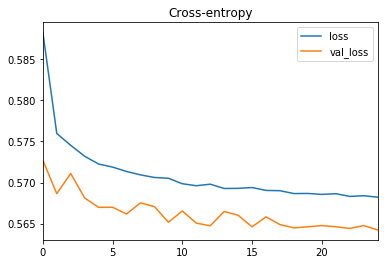

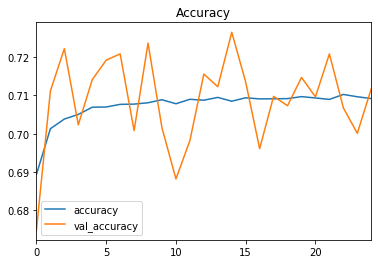

In [18]:

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    min_delta=0.001,
    restore_best_weights=True
)

history = best_model.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    batch_size=best_params['batch_size'],
    epochs=20,
    callbacks=[early_stopping],
    class_weight=class_weight
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title="Accuracy")

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_accuracy'].max()))



In [19]:
# Generate some accuracy metrics
score = best_model.evaluate(X_valid, y_valid)
print('Validation accuracy:', score[1])

# summarize results
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))
means = grid_search.cv_results_['mean_test_roc_auc']
stds = grid_search.cv_results_['std_test_roc_auc']
params = grid_search.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation accuracy: 0.70149815
Best: 0.699987 using {'activation': 'relu', 'batch_size': 256, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'num_hidden_layers': 2, 'optimizer': 'adam', 'units': 256}
0.696720 (0.001294) with: {'activation': 'relu', 'batch_size': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'num_hidden_layers': 2, 'optimizer': 'adam', 'units': 64}
0.697511 (0.001373) with: {'activation': 'relu', 'batch_size': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'num_hidden_layers': 2, 'optimizer': 'adam', 'units': 128}
0.698116 (0.001445) with: {'activation': 'relu', 'batch_size': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'num_hidden_layers': 2, 'optimizer': 'adam', 'units': 256}
0.697324 (0.000872) with: {'activation': 'relu', 'batch_size': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'num_hidden_layers': 2, 'optimizer': 'adam', 'units': 512}
0.697432 (0.001789) with: {'activation': 'relu', 'batch_size': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'num_h

In [20]:
best_model.summary() # v important in this model to see no. hidden layers

Model: "sequential_130"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_454 (Bat (None, 10)                40        
_________________________________________________________________
dense_454 (Dense)            (None, 256)               2816      
_________________________________________________________________
batch_normalization_455 (Bat (None, 256)               1024      
_________________________________________________________________
dropout_324 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_455 (Dense)            (None, 256)               65792     
_________________________________________________________________
batch_normalization_456 (Bat (None, 256)               1024      
_________________________________________________________________
dropout_325 (Dropout)        (None, 256)            

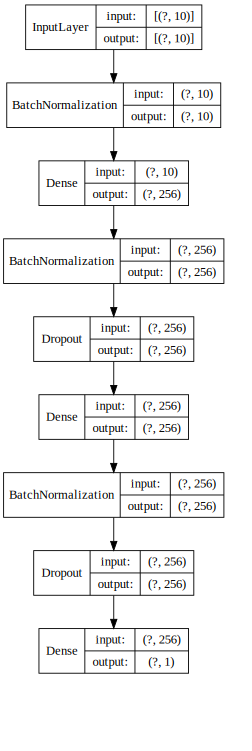

In [21]:
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot

SVG(model_to_dot(best_model, show_shapes=True, show_layer_names=False, dpi=65).create(prog='dot', format='svg'))


In [22]:
print(best_params['optimizer'])
print(best_params['dropout_rate'])
print(best_params['batch_size'])

print(best_params)

adam
0.2
256
{'activation': 'relu', 'batch_size': 256, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'num_hidden_layers': 2, 'optimizer': 'adam', 'units': 256}


True
704876/1 - 46s - loss: 0.5946 - accuracy: 0.7027
Validation loss: 0.569849546874837
Validation accuracy: 0.70269096
704876/1 - 30s


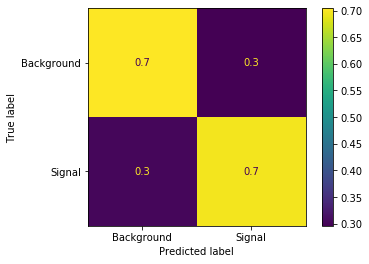

Total signal processes; 1.0
Total background processes; 1.0
265842
There is 142540 signal in the set
The model predicted 123302 more ones than in reality
439034
There is 562336 background in the set
The model predicted -123302 more ones than in reality


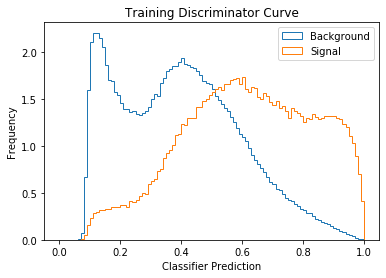

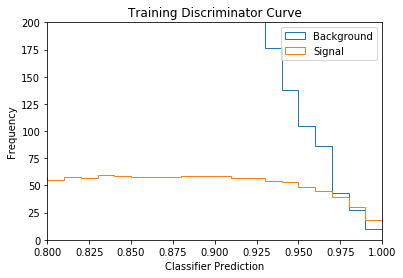

In [23]:
# evaluate the model on the training data, confusion matrix and discriminator curve

gpu_available = tf.test.is_gpu_available()
print(gpu_available)   # check still on the gpu

model = best_model

val_loss, val_acc = model.evaluate(X_train, y_train, verbose = 2)    

print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

y_pred = model.predict(X_train, verbose = 2)
y_pred_round = np.round(y_pred)
#print(y_pred)

# compute the confusion matrix

cm = confusion_matrix(y_train, y_pred_round, normalize = 'true')   #, normalize = 'true')  #,'true' ‘pred’, ‘all’},)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm) 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Background', 'Signal']) # other env

disp.plot()
plt.show()

print('Total signal processes;', cm[1,0]+cm[1,1])
print('Total background processes;', cm[0,0]+cm[0,1])

# Check if order of y_valid is the same order as y_pred
# expect to be the ssame order if accuracy is same as validation accuracy above.

# list of true outcomes
y_train_list = list(y_train)

# list of rounded predictions 
y_pred_round_list = list(y_pred_round)

data_test = {'True_Val': y_train_list, 'Predicted': list(y_pred), 'Round Prediction': y_pred_round_list}
df_test = pd.DataFrame(data_test)

# Easiest to reorder df, so all 0 (background) are first and then 1's (signal)

#Verified, works
df_test = df_test.sort_values(by='True_Val')
df_test

# Convert arrays to scalars
df_test['Round Prediction'] = df_test['Round Prediction'].apply(lambda x: x[0])
        
pred_one = df_test['Round Prediction'].value_counts()[1.0]
ones_in_set = df_test['True_Val'].value_counts()[1]

# Print the result
print(pred_one)
print('There is', ones_in_set, 'signal in the set')
print('The model predicted',pred_one-ones_in_set ,'more ones than in reality')


pred_zeros = df_test['Round Prediction'].value_counts()[0.0]
zeros_in_set = df_test['True_Val'].value_counts()[0]

# Print the result
print(pred_zeros)
print('There is', zeros_in_set, 'background in the set')   #agrees w/ confusion matrix
print('The model predicted', pred_zeros-zeros_in_set,'more ones than in reality')


#Split df into signal and bg

df_bg = df_test[df_test['True_Val'] == 0]
df_signal = df_test[df_test['True_Val'] == 1]

# Make discriminator curves, Histogram

# manipluate data so can be used for Histograms
lst_bg_predicted = []
for i in df_bg['Predicted']:
    lst_bg_predicted.append(i)

lst_of_values_bg_pred_train = [arr.item() for arr in lst_bg_predicted]

lst_signal_predicted = []
for i in df_signal['Predicted']:
    lst_signal_predicted.append(i)

lst_of_values_signal_pred_train = [arr.item() for arr in lst_signal_predicted]

binwidth = 0.01
bins=np.arange(0, 1 + binwidth, binwidth)
    

#Unweighted, normalised
plt.hist(x= lst_of_values_bg_pred_train, bins=bins, density = True, histtype = 'step', label = 'Background')
plt.hist(x= lst_of_values_signal_pred_train, bins=bins, density = True, histtype = 'step', label = 'Signal')
plt.title('Training Discriminator Curve')
plt.xlabel('Classifier Prediction')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#Weighted to xs_weights x 300000, need to be toproportion of full dataset too
#normalised

plt.hist(x= lst_of_values_bg_pred_train, bins=bins,  weights = df_weights[:len(lst_of_values_bg_pred_train),1]*3e5*1/0.8,
         histtype = 'step', label = 'Background')
plt.hist(x= lst_of_values_signal_pred_train, bins=bins, weights = df_weights[:len(lst_of_values_signal_pred_train),3]*3e5*1/0.8,
         histtype = 'step', label = 'Signal')
plt.title('Training Discriminator Curve')
plt.xlabel('Classifier Prediction')
plt.ylabel('Frequency')
plt.xlim(0.8,1)    #zoom in on 0.9 to 1 region
plt.ylim(0,200)    # need to zoom in
plt.legend()
plt.show()


#start dropping bins for signifucance part, calc Z and plot, should get curve that peaks

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation loss: 0.5696760652068253
Validation accuracy: 0.70149815


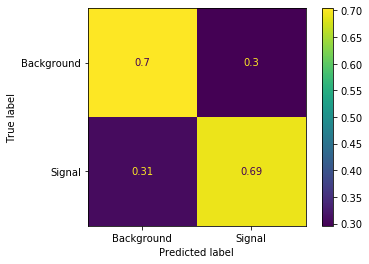

Total signal processes; 1.0
Total background processes; 1.0


In [24]:
# evaluate the model on the validation data

model = best_model 

val_loss, val_acc = model.evaluate(X_valid, y_valid)   
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

y_pred = model.predict(X_valid)
y_pred_round = np.round(y_pred)

# compute the confusion matrix
cm = confusion_matrix(y_valid, y_pred_round, normalize = 'true')    #,'true' ‘pred’, ‘all’},)#
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Background', 'Signal']) # other env
#disp = ConfusionMatrixDisplay(confusion_matrix=cm)   
disp.plot()
plt.show()

print('Total signal processes;', cm[1,0]+cm[1,1])
print('Total background processes;', cm[0,0]+cm[0,1])

# can see no class weights

In [ ]:
# #using a permutation method to see what features are important

# # Get the number of features
# n_features = X_valid.shape[1]

# # Initialize an array to store feature importances
# importances = np.zeros(n_features)

# # Calculate the feature importances using the permutation feature importance method
# # Drops each variable one at a time 
# for i in range(n_features):
#     print(i)    #counter to check is working, should go to 40
#     feature_name = X_valid.columns[i]
#     X_permuted = X_valid.copy().values
#     X_permuted[:, i] = np.random.permutation(X_permuted[:, i])
#     y_permuted = model.predict(X_permuted)
#     importances[i] = np.abs(y_permuted - y_pred).mean()
#     #importances[i] = (y_permuted - y_pred).mean()    #try without a abs, see if positively or negatively affected by removal?
#     print(f"Permuted feature {feature_name}")

# # Normalize the feature importances
# importances /= importances.sum()   # importances sum to 1, so can be taken as a literal how important a variable
# # is for the model

# print(importances)  # using abs

# print()#

# print(np.sort(importances))

# # np.random.permutation randomly permutes (rearranges in a random order) the elements.
# # In this case, it is used to shuffle the values in a single column of the X_permuted array.
# # Guess then this variable isnt useful in the prediction

In [47]:
# importances_dict = dict(zip(importances, X_valid.columns))
# # key:value

# #print(combined_dict)

# # get values for keys less than 0.01
# values = []
# for key, value in importances_dict.items():
#     if key < 0.01:
#         values.append(value)

# # print the values
# print(values)


In [48]:
# get indices of numbers less than 0.01
# for i in range(len(importances)):
#     if importances[i] < 0.05:
#         print(X_valid.columns[i])

In [25]:
# Check if order of y_valid is the same order as y_pred
# expect to be the ssame order if accuracy is same as validation accuracy above.

# list of true outcomes
y_valid_list = list(y_valid)

# list of rounded predictions 
y_pred_round_list = list(y_pred_round)

# list of whether these are same    
z=[]
for i in range(len(y_valid_list)):
    if y_valid_list[i]==y_pred_round_list[i]:
        z.append(1)
    else:
        z.append(0)
        
print(sum(z)/len(z))

# Set a tolerance
tol = 0.0001
print(val_acc - tol < sum(z)/len(z) < val_acc + tol)

# If true, suggests are in same order 

0.701498127340824
True


In [26]:
print(min(y_pred))
max(y_pred)

[0.06538224]


array([0.9999265], dtype=float32)

In [27]:
data = {'True_Val': y_valid_list, 'Predicted': list(y_pred), 'Round Prediction': y_pred_round_list}
df = pd.DataFrame(data)

# Easiest to reorder df, so all 0 (background) are first and then 1's (signal)

#Verified, works
df = df.sort_values(by='True_Val')
df

# Convert arrays to scalars
df['Round Prediction'] = df['Round Prediction'].apply(lambda x: x[0])

In [28]:
# Check that they maintained order in the df:

lst=[]
for i in range(len(df)):
    if df['True_Val'][i] == df['Round Prediction'][i]:
        lst.append(1)
    else:
        (lst.append(0))
print(sum(lst)/len(lst))

# Set a tolerance
tol = 0.0001
print(val_acc - tol < sum(lst)/len(lst) < val_acc + tol)

# If true, suggests are in same order 

0.701498127340824
True


In [29]:
pred_one = df['Round Prediction'].value_counts()[1.0]
ones_in_set = df['True_Val'].value_counts()[1]

# Print the result
print(pred_one)
print('There is', ones_in_set, 'signal in the set')
print('The model predicted',pred_one-ones_in_set ,'more ones than in reality')


pred_zeros = df['Round Prediction'].value_counts()[0.0]
zeros_in_set = df['True_Val'].value_counts()[0]

# Print the result
print(pred_zeros)
print('There is', zeros_in_set, 'background in the set')   #agrees w/ confusion matrix
print('The model predicted', pred_zeros-zeros_in_set,'more ones than in reality')


66156
There is 35318 signal in the set
The model predicted 30838 more ones than in reality
110064
There is 140902 background in the set
The model predicted -30838 more ones than in reality


now first half of df is background, other half is signal

PROBLEM, TEST AND VALID WAS SPLIT RANDOMLY, SO NOT ACTUALLY SAME AMOUNT OF 0's AND 1's

Not a problem, but need to check if should be like this

 A couple of options, I could:

Deal with it, and let there be uneven amounts of 1's and 0's

OR

Go back to test_train_split, and apply individually to signal and background and then sum them?

This would guarantee 50/50


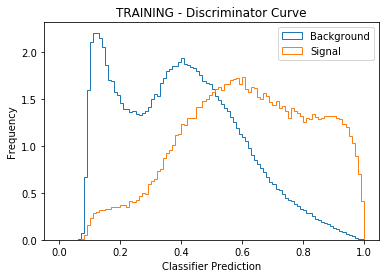

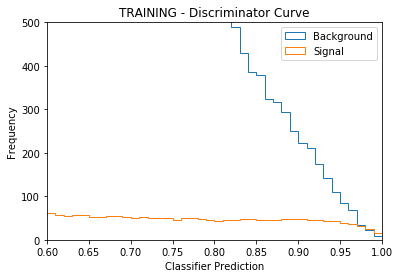

In [30]:
# Training Discriminator curves

#Unweighted, normalised
plt.hist(x= lst_of_values_bg_pred_train, bins=bins, density = True, histtype = 'step', label = 'Background')
plt.hist(x= lst_of_values_signal_pred_train, bins=bins, density = True, histtype = 'step', label = 'Signal')
plt.title('TRAINING - Discriminator Curve')
plt.xlabel('Classifier Prediction')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#Weighted to xs_weights x 300000, need to be toproportion of full dataset too
#normalised


plt.hist(x= lst_of_values_bg_pred_train, bins=bins,  weights = df_weights[:len(lst_of_values_bg_pred_train),1]*3e5,
         histtype = 'step', label = 'Background')
plt.hist(x= lst_of_values_signal_pred_train, bins=bins, weights = df_weights[:len(lst_of_values_signal_pred_train),3]*3e5,
         histtype = 'step', label = 'Signal')
plt.title('TRAINING - Discriminator Curve')
plt.xlabel('Classifier Prediction')
plt.ylabel('Frequency')
plt.xlim(0.6,1)    #zoom in on 0.9 to 1 region
plt.ylim(0,500)    # need to zoom in
plt.legend()
plt.show()


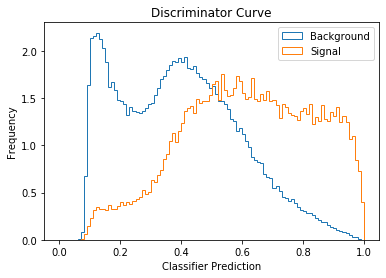

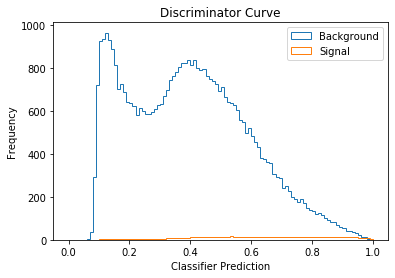

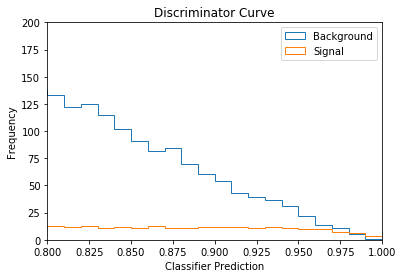

In [31]:
#Split df into signal and bg

df_bg = df[df['True_Val'] == 0]
df_signal = df[df['True_Val'] == 1]

# Make Validation discriminator curves, Histogram

# manipluate data so can be used for Histograms
lst_bg_predicted = []
for i in df_bg['Predicted']:
    lst_bg_predicted.append(i)

lst_of_values_bg_pred = [arr.item() for arr in lst_bg_predicted]

lst_signal_predicted = []
for i in df_signal['Predicted']:
    lst_signal_predicted.append(i)

lst_of_values_signal_pred = [arr.item() for arr in lst_signal_predicted]

binwidth = 0.01
bins=np.arange(0, 1 + binwidth, binwidth)

#Unweighted, normalised
plt.hist(x= lst_of_values_bg_pred, bins=bins, density = True, histtype = 'step', label = 'Background')
plt.hist(x= lst_of_values_signal_pred, bins=bins, density = True, histtype = 'step', label = 'Signal')
plt.title('Discriminator Curve')
plt.xlabel('Classifier Prediction')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#Weighted to xs_weights x 300000, need to be toproportion of full dataset too
#normalised
plt.hist(x= lst_of_values_bg_pred, bins=bins,  weights = df_weights[:len(lst_of_values_bg_pred),1]*3e5,
         histtype = 'step', label = 'Background')
plt.hist(x= lst_of_values_signal_pred, bins=bins, weights = df_weights[:len(lst_of_values_signal_pred),3]*3e5,
         histtype = 'step', label = 'Signal')
plt.title('Discriminator Curve')
plt.xlabel('Classifier Prediction')
plt.ylabel('Frequency')
#plt.xlim(0.9,1)    #zoom in on 0.9 to 1 region
#plt.ylim(0,200)    # need to zoom in
plt.legend()
plt.show()
    
plt.hist(x= lst_of_values_bg_pred, bins=bins,  weights = df_weights[:len(lst_of_values_bg_pred),1]*3e5,
         histtype = 'step', label = 'Background')
plt.hist(x= lst_of_values_signal_pred, bins=bins, weights = df_weights[:len(lst_of_values_signal_pred),3]*3e5,
         histtype = 'step', label = 'Signal')
plt.title('Discriminator Curve')
plt.xlabel('Classifier Prediction')
plt.ylabel('Frequency')
plt.xlim(0.8,1)    #zoom in on 0.9 to 1 region
plt.ylim(0,200)    # need to zoom in
plt.legend()
plt.show()


#start dropping bins for signifucance part, calc Z and plot, should get curve that peaks

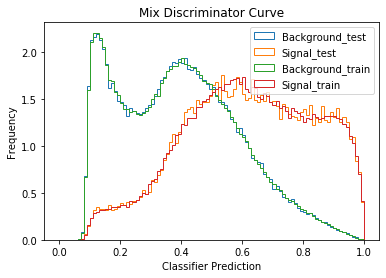

In [32]:
# Test and Training overlayed

#Unweighted, normalised
plt.hist(x= lst_of_values_bg_pred, bins=bins, density = True, histtype = 'step', label = 'Background_test')
plt.hist(x= lst_of_values_signal_pred, bins=bins, density = True, histtype = 'step', label = 'Signal_test')
plt.title('Test - Discriminator Curve')
plt.xlabel('Classifier Prediction')
plt.ylabel('Frequency')
plt.legend()


#Unweighted, normalised
plt.hist(x= lst_of_values_bg_pred_train, bins=bins, density = True, histtype = 'step', label = 'Background_train')
plt.hist(x= lst_of_values_signal_pred_train, bins=bins, density = True, histtype = 'step', label = 'Signal_train')
plt.title('Mix Discriminator Curve')
plt.xlabel('Classifier Prediction')
plt.ylabel('Frequency')
plt.legend()
plt.show()

num_bg_events =  217678.7500371933
num_signal_events =  4367.311523348093


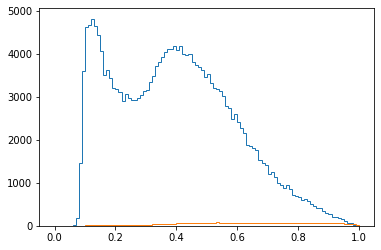

In [33]:
#Calculate number of events

n_bg, bins_bg, patches_bg = plt.hist(x= lst_of_values_bg_pred, bins=bins, weights = df_weights[:len(lst_of_values_bg_pred),1]*3e5*5,
         histtype = 'step', label = 'Background')
n_signal, bins_signal, patches_signal = plt.hist(x= lst_of_values_signal_pred, bins=bins, weights = df_weights[:len(lst_of_values_signal_pred),3]*3e5*5,
         histtype = 'step', label = 'Signal')

# calculate the number of events
num_bg_events = np.sum(n_bg)
num_signal_events = np.sum(n_signal)

print('num_bg_events = ', num_bg_events)
print('num_signal_events = ', num_signal_events)

In [ ]:
# #plot ROC curves

# y_true = df['True_Val']
# y_score = df['Predicted']

# # calculate the false positive rate and true positive rate
# fpr, tpr, thresholds = roc_curve(y_true, y_score)

# # calculate the area under the ROC curve
# roc_auc = auc(fpr, tpr)

# # plot the ROC curve
# plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic')
# plt.legend(loc="lower right")
# plt.show()

# print(roc_auc)  #79%

# print(len(thresholds))



In [ ]:
# data_roc = {'thresholds': thresholds, 'tpr': tpr, 'fpr': fpr, 'tpr/sqrt(fpr)':tpr/np.sqrt(fpr)}
# df_roc = pd.DataFrame(data_roc)
# #df_roc
# df_roc.head(20)
# plt.plot(df_roc['thresholds'][3:], df_roc['tpr/sqrt(fpr)'][3:])
# plt.show()
# max(df_roc['tpr/sqrt(fpr)'][3:])

In [ ]:
# # Plot precision recall curve
# from sklearn.metrics import average_precision_score

# y_true = df['True_Val']
# y_score = df['Predicted']

# # calculate the precision-recall curve
# precision, recall, _ = precision_recall_curve(y_true, y_score)

# # plot the precision-recall curve
# plt.step(recall, precision, color='b', alpha=0.2, where='post')
# plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.ylim([0.0, 1.05])
# plt.xlim([0.0, 1.0])
# plt.title('Precision-Recall Curve')
# plt.show()

# AUC = average_precision_score(y_true, y_score)   #0.793, pretty similar to roc AUC
# print(AUC)

In [34]:
df['True_Val']
x = df['Predicted']
print(x)

88109     [0.26104653]
111032     [0.5855491]
111033    [0.16594803]
111034    [0.12379736]
111035    [0.16471612]
              ...     
27764     [0.90463454]
141597    [0.78419554]
27763     [0.96411705]
100490    [0.77086544]
0         [0.38542986]
Name: Predicted, Length: 176220, dtype: object


# Significance

$$ Z = \frac{s}{\sqrt(B+\sigma_s^{2})}  $$

s = number of signal

B = number of background

$\sigma_s$ = statistical uncertainty (~10% of B)

217678.7500371933
4367.311523348093


/software/deep-learning/envs/ml-microscope/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


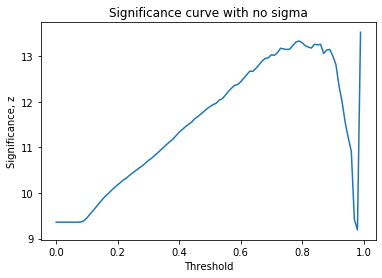

0.99
99
13.528277582302788

If cut at a threshold of 0.99 have
17.07861328125 singal events
1.59375 background events


/software/deep-learning/envs/ml-microscope/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in less


In [35]:
num_bg_events = np.sum(n_bg)
num_signal_events = np.sum(n_signal)

print(num_bg_events)
print(num_signal_events)

z = np.empty(len(bins_bg))
for i in range(len(bins_bg)):
    num_bg_events = np.sum(n_bg[i:])
    num_signal_events = np.sum(n_signal[i:])
    #print(num_signal_events)
    z_i = num_signal_events / np.sqrt(num_bg_events)
    z[i] = z_i
#print(z)


x = np.linspace(0,1,len(z))
plt.plot(bins_bg,z[:])
#plt.xlim([0, 1.0])
#plt.ylim([0.0, 1.05])
plt.xlabel('Threshold')
plt.ylabel('Significance, z')
plt.title('Significance curve with no sigma')
plt.show()


mask = z < 1e10     #just so doesnt include infs
index_of_max = np.argmax(z[mask])
max_value = np.amax(z[mask])


#index_of_max = np.nanargmax(z[:])
#max_value = np.nanmax(z[:])     # 1 point before last, should probs generalise so that can deal w inf etc 
max_bin = bins_bg[index_of_max]
print(max_bin)
print(index_of_max)
print(max_value)

# significance = sigmna, 6.5 signma, 5 sigma

num_bg_threshold = np.sum(n_bg[index_of_max:])
num_signal_threshold = np.sum(n_signal[index_of_max:])

print()
print('If cut at a threshold of', index_of_max/100, 'have')
print(num_signal_threshold, 'singal events')
print(num_bg_threshold, 'background events')

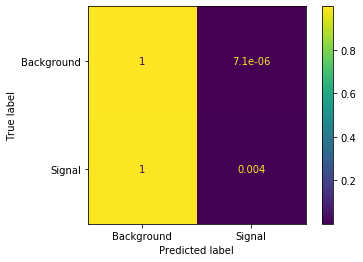

Total signal processes; 1.0
Total background processes; 1.0


In [37]:
# Confusion matricies with new threshold at max significance

# calculates prediction values
#y_pred = model.predict(X_valid) 

significance_threshold = max_bin
y_pred_threshold = np.where(y_pred >= significance_threshold, 1, 0)

# compute the confusion matrix
cm = confusion_matrix(y_valid, y_pred_threshold, normalize = 'true')    #,'true' ‘pred’, ‘all’},)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm)   
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Background', 'Signal']) # other env
disp.plot()
plt.show()

print('Total signal processes;', cm[1,0]+cm[1,1])
print('Total background processes;', cm[0,0]+cm[0,1])

217678.7500371933
4367.311523348093


/software/deep-learning/envs/ml-microscope/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


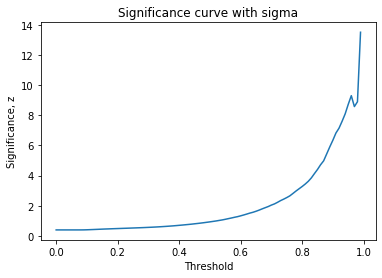

0.99
99
13.501406987094535

If cut at a threshold of 0.99 have
17.07861328125 singal events
1.59375 background events


/software/deep-learning/envs/ml-microscope/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in less


In [38]:
# significance with statistical uncertainty term

num_bg_events = np.sum(n_bg)
num_signal_events = np.sum(n_signal)

print(num_bg_events)
print(num_signal_events)

z = np.empty(len(bins_bg))
for i in range(len(bins_bg)):
    num_bg_events = np.sum(n_bg[i:])
    num_signal_events = np.sum(n_signal[i:])
    #print(num_signal_events)
    z_i = num_signal_events / np.sqrt(num_bg_events + (0.05*num_bg_events)**2)
    
    z[i] = z_i
#print(z)


x = np.linspace(0,1,len(z))
plt.plot(bins_bg,z[:])
#plt.xlim([0, 1.0])
#plt.ylim([0.0, 1.05])
plt.xlabel('Threshold')
plt.ylabel('Significance, z')
plt.title('Significance curve with sigma')
plt.show()


mask = z < 1e10     #just so doesnt include infs
index_of_max = np.argmax(z[mask])
max_value = np.amax(z[mask])


#index_of_max = np.nanargmax(z[:])
#max_value = np.nanmax(z[:])     # 1 point before last, should probs generalise so that can deal w inf etc 
max_bin = bins_bg[index_of_max]
print(max_bin)
print(index_of_max)
print(max_value)

num_bg_threshold = np.sum(n_bg[index_of_max:])
num_signal_threshold = np.sum(n_signal[index_of_max:])
print()
print('If cut at a threshold of', index_of_max/100, 'have')
print(num_signal_threshold, 'singal events')
print(num_bg_threshold, 'background events')
# significance = sigmna, 6.5 signma, 5 sigma

/software/deep-learning/envs/ml-microscope/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/software/deep-learning/envs/ml-microscope/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


217678.7500371933
4367.311523348093


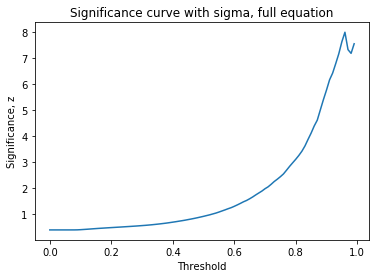

0.96
96
7.994646545166427

If cut at a threshold of 0.96 have
133.89111328125 singal events
150.640625

/software/deep-learning/envs/ml-microscope/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in less


 background events


In [39]:
# significance with systematic uncertainty term, full equation

num_bg_events = np.sum(n_bg)
num_signal_events = np.sum(n_signal)

print(num_bg_events)
print(num_signal_events)

z = np.empty(len(bins_bg))
for i in range(len(bins_bg)):
    b = np.sum(n_bg[i:])
    s = np.sum(n_signal[i:])
    #print(num_signal_events)
    sigma = 0.05*b
    
    part1 = (s+b)*np.log(((s+b)*(b+sigma**2))/(b**2+((s+b)*sigma**2)))
    part2 = (b**2/sigma**2)*np.log(1+((sigma**2*s)/(b*(b+sigma**2))))
    
    z_i = (2*(part1-part2))**(1/2)

    
    z[i] = z_i
#print(z)
#print(z)


x = np.linspace(0,1,len(z))
plt.plot(bins_bg,z[:])
#plt.xlim([0, 1.0])
#plt.ylim([0.0, 1.05])
plt.xlabel('Threshold')
plt.ylabel('Significance, z')
plt.title('Significance curve with sigma, full equation')
plt.show()


mask = z < 1e10     #just so doesnt include infs
index_of_max = np.argmax(z[mask])
max_value = np.amax(z[mask])


#index_of_max = np.nanargmax(z[:])
#max_value = np.nanmax(z[:])     # 1 point before last, should probs generalise so that can deal w inf etc 
max_bin = bins_bg[index_of_max]
print(max_bin)
print(index_of_max)
print(max_value)

num_bg_threshold = np.sum(n_bg[index_of_max:])
num_signal_threshold = np.sum(n_signal[index_of_max:])
print()
print('If cut at a threshold of', index_of_max/100, 'have')
print(num_signal_threshold, 'singal events')
print(num_bg_threshold, 'background events')
# significance = sigmna, 6.5 signma, 5 sigma

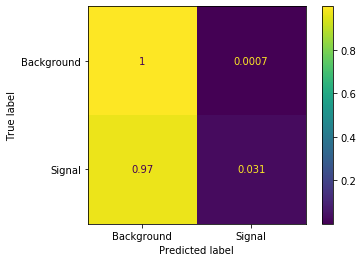

Total signal processes; 1.0
Total background processes; 1.0


In [40]:
# Confusion matricies with new threshold at max significance with statisitcal uncertainty

# calculates prediction values
#y_pred = model.predict(X_valid) 

significance_threshold = max_bin
y_pred_threshold = np.where(y_pred >= significance_threshold, 1, 0)

# compute the confusion matrix
cm = confusion_matrix(y_valid, y_pred_threshold, normalize = 'true')    #,'true' ‘pred’, ‘all’},)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm)   
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Background', 'Signal']) # other env
disp.plot()
plt.show()

print('Total signal processes;', cm[1,0]+cm[1,1])
print('Total background processes;', cm[0,0]+cm[0,1])